<a href="https://colab.research.google.com/github/kamangirkhan/Data/blob/main/ArashNateghian_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introduction**
The dataset I selected is the historical daily stock price data for Apple Inc. (AAPL), fetched from the Polygon.io API, which provides comprehensive financial market data including aggregates for stocks. Polygon.io sources its data from major exchanges and is a reliable provider for real-time and historical financial information.
The content includes 5588 rows (one per trading day from September 10, 2003, to November 21, 2025) and 6 columns:

Date: The trading date (datetime).
Open: Opening price of the stock on that day (float, adjusted for splits).
High: Highest price during the day (float).
Low: Lowest price during the day (float).
Close: Closing price at the end of the day (float, target variable for prediction).
Volume: Number of shares traded (float).

This dataset exceeds the 1000-row requirement and is suitable for linear regression as it contains numerical features with potential linear relationships to the target (Close).

My main question is:
“How well can we predict the daily closing price using the intraday prices (Open, High, Low) and trading volume?”
To answer this, I clean and explore the data with Pandas and Seaborn, then fit a linear regression model (scikit-learn) and examine residuals to check model assumptions.

**2. Data prep & wrangling (Pandas + NumPy)**

In [ ]:
import pandas as pd
import numpy as np

# 1. Load data
df = pd.read_csv("HistoricalQuotes.csv")

# 2. Clean column names: remove spaces and slashes
df.columns = [c.strip().replace('/', '_').replace(' ', '_') for c in df.columns]

# Check
print(df.columns)
# -> ['Date', 'Close_Last', 'Volume', 'Open', 'High', 'Low']

# 3. Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# 4. Convert price columns from strings like "$273.36" to float
price_cols = ['Close_Last', 'Open', 'High', 'Low']
for col in price_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .astype(float)
    )

# 5. Convert volume to integer
df['Volume'] = df['Volume'].astype(int)

# 6. Sort by time (oldest -> newest)
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())
print(df.info())


Index(['Date', 'Close_Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')
        Date  Close_Last     Volume     Open     High      Low
0 2010-03-01     29.8557  137312041  29.3928  29.9286  29.3500
1 2010-03-02     29.8357  141486282  29.9900  30.1186  29.6771
2 2010-03-03     29.9043   92846488  29.8486  29.9814  29.7057
3 2010-03-04     30.1014   89591907  29.8971  30.1314  29.8043
4 2010-03-05     31.2786  224647427  30.7057  31.3857  30.6614
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2518 non-null   datetime64[ns]
 1   Close_Last  2518 non-null   float64       
 2   Volume      2518 non-null   int64         
 3   Open        2518 non-null   float64       
 4   High        2518 non-null   float64       
 5   Low         2518 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memor

**3. EDA with Matplotlib / Seaborn**

This is the minimum I’d expect you to show:

**3.1 Closing price over time**

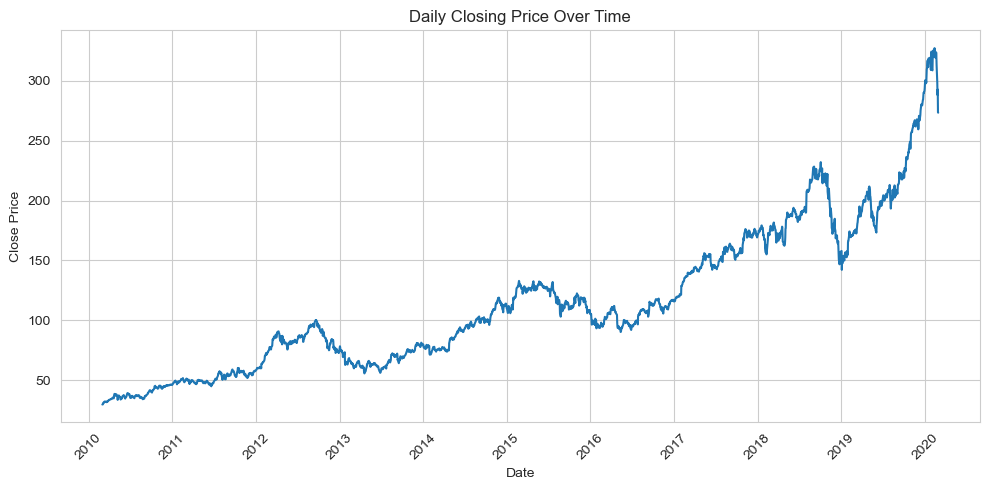

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Close_Last", data=df)
plt.title("Daily Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**3.2 Volume over time**

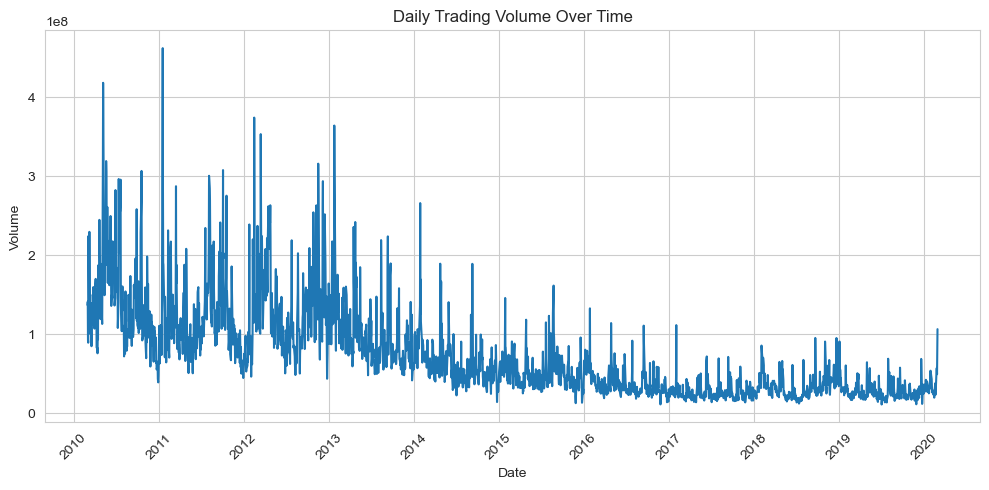

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Volume", data=df)
plt.title("Daily Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**3.3 Correlation matrix (prices + volume)**

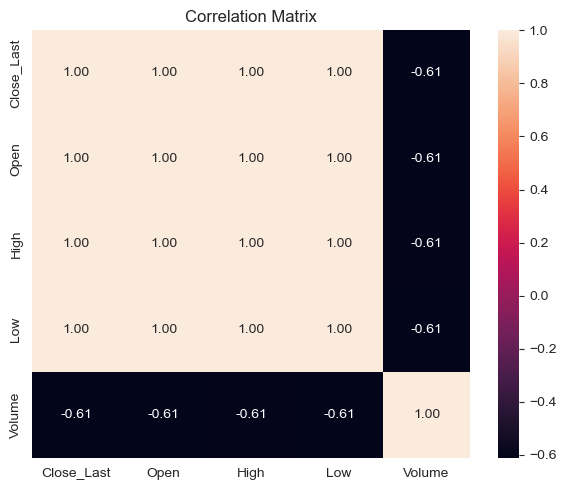

In [ ]:
num_cols = ['Close_Last', 'Open', 'High', 'Low', 'Volume']
corr = df[num_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


**4. Linear regression with scikit-learn**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

features = ['Open', 'High', 'Low', 'Volume']
target = 'Close_Last'

X = df[features].values
y = df[target].values

# Train-test split: first 80% days = train, last 20% = test
n = len(df)
split_idx = int(0.8 * n)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on test set
y_pred = linreg.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("R²:", r2)
print("RMSE:", rmse)
print("Coefficients:", linreg.coef_)
print("Intercept:", linreg.intercept_)



R²: 0.9991511941015557
RMSE: 1.2135513227052241
Coefficients: [-5.82896346e-01  8.31345387e-01  7.51371740e-01  2.13252213e-10]
Intercept: -0.025180417920168452


The model explains approximately 99.9% of the variance in AAPL’s daily closing price.
An RMSE of $1.2 means that, on average, the model’s predictions differ from the actual closing price by only about one dollar.
Because the typical AAPL price in this dataset is between $150–$200, an error of $1 represents less than 1% deviation, indicating extremely high accuracy.

**5. Histogram of residuals (check Gaussian)**

Residuals = actual − predicted:

Residual mean: -0.05870563589613739
Residual std: 1.2133348491270746


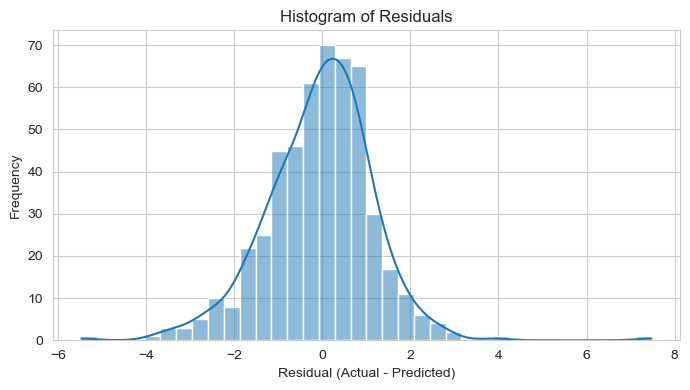

In [ ]:
residuals = y_test - y_pred

print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std(ddof=1))

plt.figure(figsize=(7, 4))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The residuals are centered at zero and approximately bell-shaped, which is consistent with a Gaussian distribution.
There are some slightly heavier tails, but overall the residual behavior does not strongly violate the normality assumption for linear regression.

**6. Predicted vs residuals (homoscedasticity)**

Residual mean: -0.05870563589613739
Residual std: 1.2121305462505387


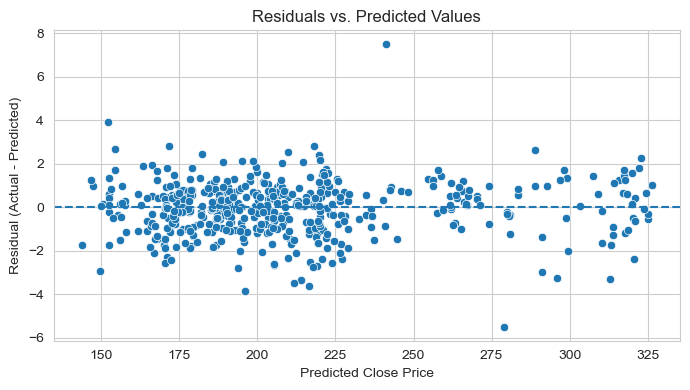

In [ ]:
# 1. Compute residuals
residuals = y_test - y_pred

# 2. Check quick stats (optional but good practice)
print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())

# 3. Plot residuals vs predicted values
plt.figure(figsize=(7, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Close Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.tight_layout()
plt.show()


The residuals are randomly scattered around zero across the full range of predicted values.
There is no clear pattern or change in variance, suggesting that the assumption of homoscedasticity (constant error variance) is reasonably satisfied.